# Charactersitics of tracked cyclones

* Distance travelled
* Lifetime
* Average speed
* Maximum vorticity
* Minimum SLP
* Approximate diameter

First, import all the modules.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fastprogress import progress_bar, master_bar
import string

from common_defs import nyr, aliases, winters, datasets, period
import mypaths
from plot_utils import use_style

from octant.core import TrackRun, OctantTrack
import octant

octant.__version__

'v0.0.21+0.g96be4b6.dirty'

In [2]:
# import warnings
# warnings.filterwarnings('ignore', category=RuntimeWarning)

In [3]:
use_style()

In [4]:
runs2process = dict(era5=[0], interim=[0])
subsets = ["pmc"]

In [5]:
track_runs = {}
for dset in datasets:
    track_runs[dset] = {}
    for run_num in runs2process[dset]:
        track_runs[dset][f"run{run_num:03d}"] = TrackRun.from_archive(
            mypaths.procdir / f"{dset}_run{run_num:03d}_{period}.h5"
        )

In [6]:
# subset = 'moderate'
# vo = TR[subset].groupby('track_idx').apply(lambda x: x.max_vort)

# mean_area = TR[subset].groupby('track_idx').apply(lambda x: x.area.mean())

# max_area = TR[subset].groupby('track_idx').apply(lambda x: x.area.max())

# med_area = TR[subset].groupby('track_idx').apply(lambda x: x.area.median())

# plt.scatter(vo, max_area, alpha=0.7)
# plt.scatter(vo, med_area, alpha=0.7)
# plt.scatter(vo, mean_area, alpha=0.7)

Define what statistic to calculate according to bins and what title to use in the plot below.

In [7]:
vrbl_dict = dict(
    #    gen_lys_dist_km=dict(bins=np.linspace(0, 1800, 7), title='Genesis-lysis distance [km]'),
    lifetime_h=dict(bins=[0, 6, 18, 36, 54, 72], title="Life time [h]"),
    total_dist_km=dict(bins=np.linspace(0, 3200, 5), title="Total track distance [km]"),
    average_speed=dict(bins=np.linspace(16, 96, 6), title="Propagation velocity [$km$ $h^{-1}$]"),
    max_vort=dict(bins=np.linspace(0, 10, 6), title="Maximum vorticity [$10^{-4}$ $s^{-1}$]"),
    area=dict(bins=np.linspace(0, 400, 5), title="Vorticity area diameter [km]"),
    slp=dict(bins=np.linspace(980, 1020, 5), title="Min SLP [hPa]"),
)

Extract statistics for every track in both datasets.

In [8]:
track_summary = {}
for dset in datasets:
    track_summary[dset] = {}
    for subset in subsets:
        _data = {}
        for vrbl_name in progress_bar(vrbl_dict.keys()):
            _data[vrbl_name] = []
            for i, ct in track_runs[dset]["run000"][subset].groupby("track_idx"):
                if vrbl_name == "area":
                    _data[vrbl_name].append(2 * (getattr(ct, vrbl_name).mean() / np.pi) ** 0.5)
                elif vrbl_name == "slp":
                    _data[vrbl_name].append(ct.slp.min())
                else:
                    _data[vrbl_name].append(getattr(ct, vrbl_name))

        #     [[getattr(ct, vrbl_name) if vrbl_name != 'area' else 2*(getattr(ct, vrbl_name).mean()/np.pi)**0.5
        #                                            for vrbl_name in vrbl_dict.keys()]
        #                                           for i, ct in TR[subset].groupby('track_idx')]
        track_summary[dset][subset] = pd.DataFrame(_data)
        track_summary[dset][subset].max_vort *= 1e4

Plot results as histograms.

In [9]:
plt_kw_list = [dict(color="C0", alpha=1), dict(color="C1", alpha=1)]

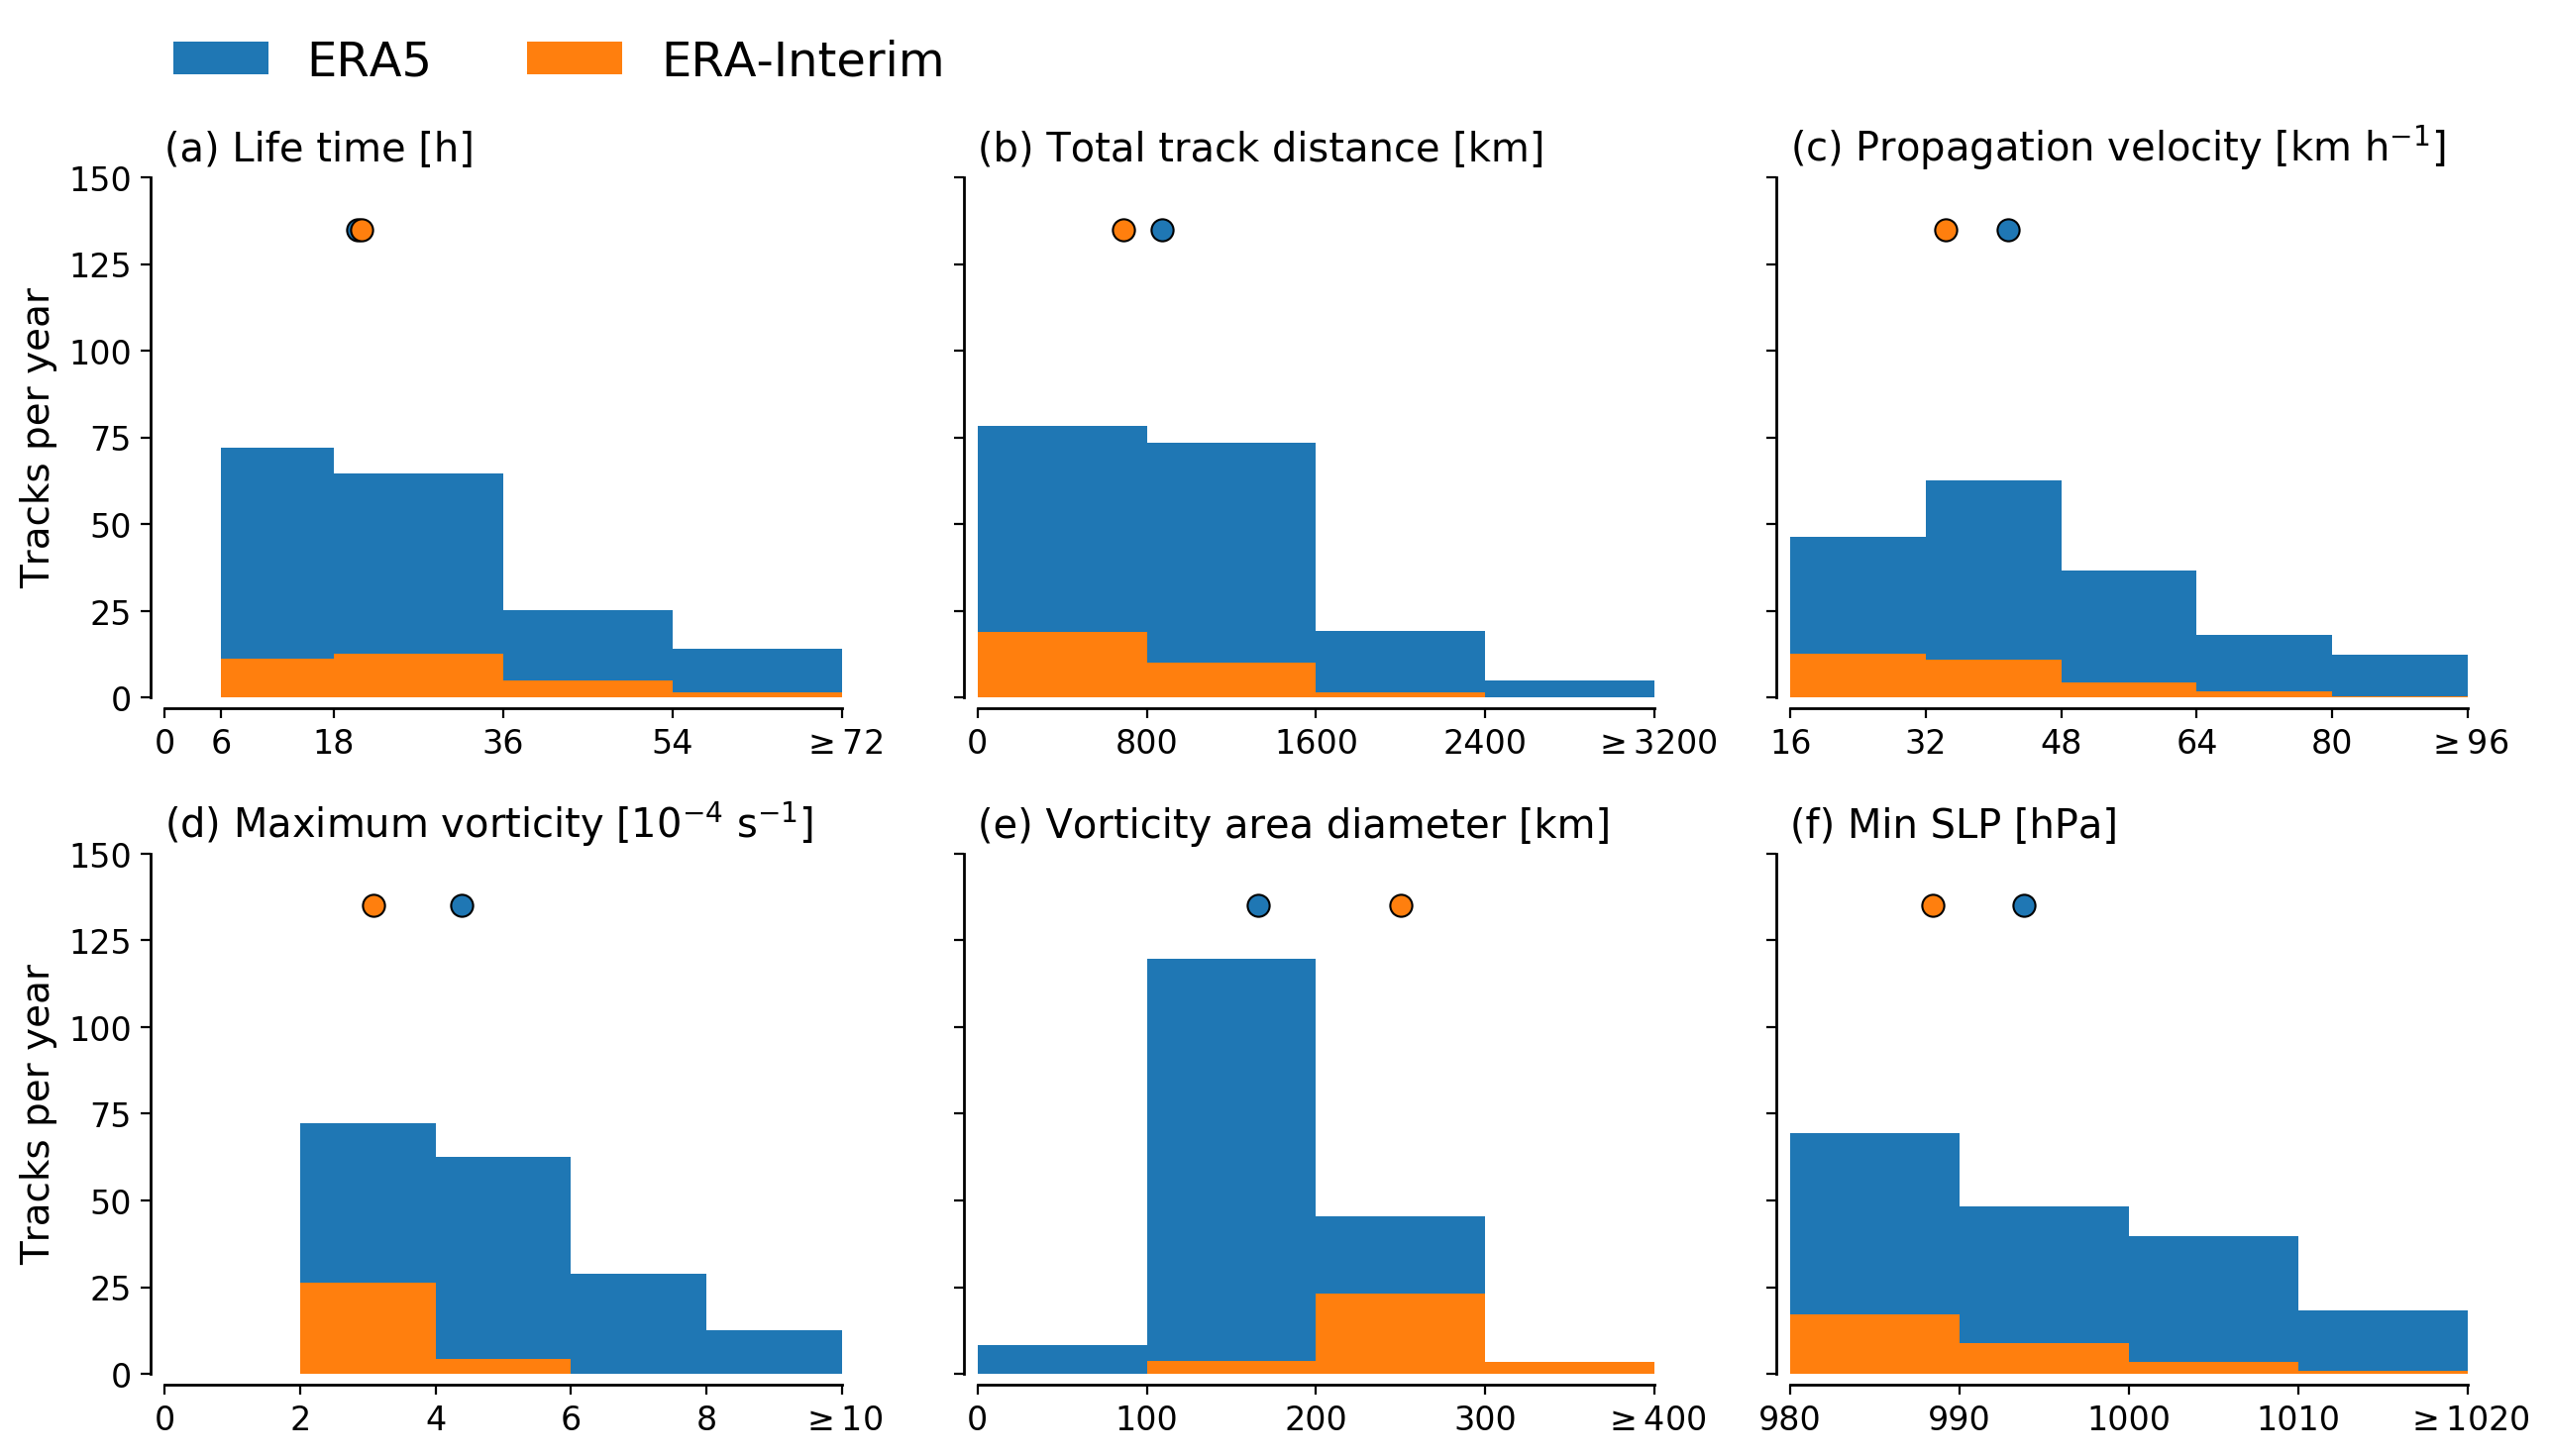

In [10]:
# import string
iletters = iter(string.ascii_lowercase)

ymax = 150

ncols = 3
nrows = 2
fig, axs = plt.subplots(
    ncols=ncols, nrows=nrows, sharey=True, gridspec_kw=dict(hspace=0.3, wspace=0.2)
)

for ax, (vrbl_name, h_kw) in zip(axs.flat, vrbl_dict.copy().items()):
    hist_kw = h_kw.copy()
    ttl = hist_kw["title"]
    bins = hist_kw["bins"]

    for dset, plt_kw in zip(datasets, plt_kw_list):
        clipped_data = np.clip(track_summary[dset][subset][vrbl_name], bins[0], bins[-1])
        clipped_data.hist(
            ax=ax,
            label=aliases[dset],
            weights=np.ones(clipped_data.shape) * 1 / nyr,
            bins=bins,
            **plt_kw,
        )
        med_val = np.median(track_summary[dset][subset][vrbl_name])
        ax.plot(
            med_val,
            0.9 * ymax,
            alpha=plt_kw.get("alpha", 1),
            mfc=plt_kw["color"],
            marker="o",
            ms=8,
            mec="k",
            mew=0.75,
            zorder=100,
        )
    ax.set_xlim(bins[0], bins[-1])
    ax.set_xticks(bins)
    xlabels = [f"{int(x)}" for x in bins]
    xlabels[-1] = f"$\geq {xlabels[-1]}$"
    ax.set_xticklabels(xlabels, rotation=0)
    ax.grid(False)
    ax.set_ylim(0, ymax)
    #     ax.set_yscale('log')
    ax.set_title(f"({next(iletters)}) {ttl}", loc="left", fontsize="large")
    #     ax.add_artist(AnchoredText(f'({next(iletters)})', loc=1, frameon=True))

    for spine in ax.spines.values():
        if spine.spine_type in ["top", "right"]:
            spine.set_linewidth(0)
        else:
            spine.set_linewidth(1)
            spine.set_position(("axes", -0.02))
            spine.set_position(("axes", -0.02))

for axrow in axs:
    axrow[0].set_ylabel("Tracks per year")
axs.flatten()[0].legend(
    fontsize="x-large", ncol=4, loc=2, bbox_to_anchor=(-0.05, 1.35), frameon=False
);

Save the figure.

In [11]:
fig.savefig(mypaths.plotdir / "characteristic_histograms")